In [1]:
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Flatten , Dropout , Dense , Input , AveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import numpy as np
import matplotlib.pyplot as plt
import os
import warnings
warnings.filterwarnings('ignore')

In [2]:
LEARNING_RATE = 1e-4
EPOCHS = 20
BATCH_SIZE = 32
DIRECTORY = 'D:\dataset'
CATEGORIES = ['with_mask' , 'without_mask']
print('loading images -------')
data = []
labels = []

for category in CATEGORIES :
    path = os.path.join(DIRECTORY,category)
    for img in os.listdir(path):
        img_path = os.path.join(path,img)
        image = load_img(img_path,target_size=(224,224))
        image = img_to_array(image)
        image = preprocess_input(image)
        data.append(image)
        labels.append(category)

loading images -------


In [3]:
lb =  LabelBinarizer()
labels = lb.fit_transform(labels)
labels =  to_categorical(labels)
data = np.array(data,dtype = 'float32')
labels = np.array(labels)
X_train, X_test, y_train, y_test = train_test_split(data,labels,test_size=0.2 , stratify=labels , random_state=42)

In [4]:
aug = ImageDataGenerator(rotation_range=20,
                        zoom_range=0.15,
                        width_shift_range=0.2,
                        height_shift_range=0.2,
                        shear_range=0.15,
                        horizontal_flip=True,
                        fill_mode='nearest')

In [5]:
basemodel = MobileNetV2(weights='imagenet',include_top=False,
                       input_tensor=Input(shape=(224,224,3)))
headModel = basemodel.output
headModel = AveragePooling2D(pool_size=(7,7))(headModel)
headModel = Flatten(name ='Flatten' )(headModel)
headModel = Dense(128,activation='relu')(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2,activation='softmax')(headModel)
model = Model(inputs = basemodel.input , outputs=headModel)

In [6]:
for layer in basemodel.layers :
    layer.trainable =  False
optm = Adam(learning_rate = LEARNING_RATE )
model.compile(loss='binary_crossentropy' , optimizer = optm , metrics = ['accuracy'])
H =  model.fit(aug.flow(X_train , y_train , batch_size=BATCH_SIZE),
              steps_per_epoch=len(X_train) // BATCH_SIZE,
              validation_data=(X_test,y_test),
              validation_steps=len(X_test) // BATCH_SIZE ,
              epochs = EPOCHS)

Epoch 1/20
95/95 [==============================] - 87s 861ms/step - loss: 0.4383 - accuracy: 0.8154 - val_loss: 0.1744 - val_accuracy: 0.9777
Epoch 2/20
95/95 [==============================] - 75s 784ms/step - loss: 0.1624 - accuracy: 0.9622 - val_loss: 0.0873 - val_accuracy: 0.9869
Epoch 3/20
95/95 [==============================] - 73s 770ms/step - loss: 0.1035 - accuracy: 0.9731 - val_loss: 0.0603 - val_accuracy: 0.9908
Epoch 4/20
95/95 [==============================] - 77s 815ms/step - loss: 0.0853 - accuracy: 0.9748 - val_loss: 0.0510 - val_accuracy: 0.9895
Epoch 5/20
95/95 [==============================] - 77s 811ms/step - loss: 0.0667 - accuracy: 0.9804 - val_loss: 0.0452 - val_accuracy: 0.9908
Epoch 6/20
95/95 [==============================] - 77s 811ms/step - loss: 0.0574 - accuracy: 0.9854 - val_loss: 0.0421 - val_accuracy: 0.9908
Epoch 7/20
95/95 [==============================] - 78s 825ms/step - loss: 0.0497 - accuracy: 0.9854 - val_loss: 0.0389 - val_accuracy: 0.9908

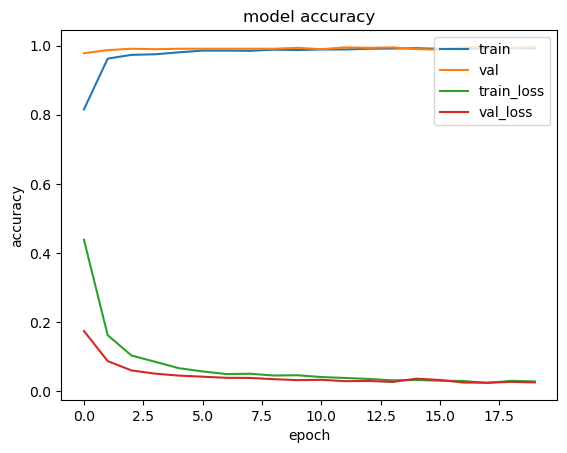

In [7]:
import keras
from matplotlib import pyplot as plt
plt.plot(H.history['accuracy'])
plt.plot(H.history['val_accuracy'])
plt.plot(H.history['loss'])
plt.plot(H.history['val_loss'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val' , 'train_loss' , 'val_loss'], loc='upper right')
plt.show()

In [8]:
for l in model.layers:
    print(l.name , l.trainable)

input_1 False
Conv1 False
bn_Conv1 False
Conv1_relu False
expanded_conv_depthwise False
expanded_conv_depthwise_BN False
expanded_conv_depthwise_relu False
expanded_conv_project False
expanded_conv_project_BN False
block_1_expand False
block_1_expand_BN False
block_1_expand_relu False
block_1_pad False
block_1_depthwise False
block_1_depthwise_BN False
block_1_depthwise_relu False
block_1_project False
block_1_project_BN False
block_2_expand False
block_2_expand_BN False
block_2_expand_relu False
block_2_depthwise False
block_2_depthwise_BN False
block_2_depthwise_relu False
block_2_project False
block_2_project_BN False
block_2_add False
block_3_expand False
block_3_expand_BN False
block_3_expand_relu False
block_3_pad False
block_3_depthwise False
block_3_depthwise_BN False
block_3_depthwise_relu False
block_3_project False
block_3_project_BN False
block_4_expand False
block_4_expand_BN False
block_4_expand_relu False
block_4_depthwise False
block_4_depthwise_BN False
block_4_depthwi

In [9]:
prediction = model.predict(X_test , batch_size = BATCH_SIZE)
pred_max = np.argmax(prediction,axis = 1)

24/24 [==============================] - 13s 458ms/step


In [10]:
print(classification_report(y_test.argmax(axis=1) , pred_max , target_names=lb.classes_))

              precision    recall  f1-score   support

   with_mask       0.99      1.00      1.00       377
without_mask       1.00      0.99      1.00       384

    accuracy                           1.00       761
   macro avg       1.00      1.00      1.00       761
weighted avg       1.00      1.00      1.00       761



In [11]:
model.save('mask_detector.model',save_format ='h5')